In [1]:
from tqdm import tqdm

In [2]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

In [60]:
from ase import io
from ase.visualize import view
from ase.build import sort, molecule
from ase.optimize import QuasiNewton, FIRE

In [4]:
from helpers import validate
from helpers import read_metrics

In [5]:
from pyace import PyACECalculator

In [6]:
%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm

mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['font.size'] = 18
# mpl.rcParams['font.family'] = 'Times'

mpl.rcParams['xtick.minor.visible'] = True
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['xtick.minor.width'] = 1.5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['xtick.minor.size'] = 3.
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.top']=True

mpl.rcParams['ytick.minor.visible'] = True
mpl.rcParams['ytick.minor.width'] = 1.5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['ytick.minor.size'] = 3.
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['ytick.right']=True

In [177]:
calc = PyACECalculator('../../upfit/10000_ladder/asi/interim_potential_ladder_step_1.yaml',
    keep_extrapolative_structures=True,
    gamma_lower_bound=1.2,
    gamma_upper_bound=10,
    stop_at_large_extrapolation=False)
calc.set_active_set('../../upfit/10000_ladder/asi/interim_potential_ladder_step_1.asi')

In [7]:
def linear_fn(x, a, b):
    return a*x + b

In [8]:
import os
import warnings
def read_log(path):
    os.system(f'cat {path}/lmp.out | grep -e Step -e Loop -n > read_log')
    file = open('read_log').readlines()
#     os.system('rm read_log')
    log_lst = list()
    for i in range(0,len(file),2):
        try:
                n1 = int(file[i].replace(':',' ').split()[0])
                n2 = int(file[i+1].replace(':',' ').split()[0])
                log_lst.append(pd.read_csv(f'{path}/lmp.out',
                                   skiprows=n1-1, nrows=n2-n1-1, sep= '\s+'))
        except:
            break

    if(len(file)%2 ==0):
        return log_lst
    else:
        warnings.warn('Last run is not finished')            
        n = int(file[-1].replace(':',' ').split()[0])
        log_lst.append(pd.read_csv(f'{path}/lmp.out', skiprows=n-1, sep= '\s+'))

    return log_lst

In [176]:
def write_lmp_file_eq(T, P, path, pot_dir):
    s= np.random.randint(99999)
    lines= ['\n',
 'units\t\tmetal\t\t\t\t\t\t## E in [eV], t in [ps], P in [10000 Pa], l in [A]\n',
 'atom_style\tatomic\t\t\t\t\t\t## mass x y z vx vy vz \n',
 '\n',
 'neighbor\t0.5 bin\t\t\t\t\t\t## neighbor list, skin = 0.5 Angstrom\n',
 'neigh_modify\tevery 2 delay 10 check yes\t\t\t## update of neighbor list\n',
 '\n',
 '############################## main variables\n',
 f'variable        seed equal {s}\n',
 '\n',
 f'variable\ttemperature equal {T}\n',
 'variable\ttempDamp equal 0.1\n',
 '\n',
 f'variable        pressure equal {P}\n',
 'variable        pressureDamp equal 1.0 \t\t\t\t# This is 1 ps\n',
 '\n',
 '##############################\n',
 '\n',
 'read_data water.dat\n',
 '\n',
 'mass\t\t1 1.008    # H\n',
 'mass\t\t2 15.9994  # O\n',
 '\n',
 '\n',
 'pair_style\tpace/extrapolation\n',
  f'pair_coeff\t* * {pot_dir}/interim_potential_ladder_step_1.yaml {pot_dir}/interim_potential_ladder_step_1.asi H O\n',
 '\n',
 'fix pace_gamma all pair 1000 pace/extrapolation gamma 1\n',
 'compute max_pace_gamma all reduce max f_pace_gamma\n',
 'variable dump_skip equal "c_max_pace_gamma < 10"\n',
 '\n',
 'dump pace_dump all custom 1000 extrapolative_structures.dump id type x y z f_pace_gamma\n',
 'dump_modify pace_dump skip v_dump_skip\n',
 'dump_modify pace_dump element H O\n',
 '\n',
 'variable max_pace_gamma equal c_max_pace_gamma',
 '\n',
 '\n',
 'timestep\t0.0005\t\t\t\t\t\t## timestep = 0.0005*ps = 0.5 fs\n',
 '\n',
 'thermo\t\t100\n',
 'thermo_style custom step etotal pe ke press temp vol density c_max_pace_gamma\n',
 '\n',
 '\n',
 'min_style cg\n',
 'minimize 0.0 5.0e-4 10000 100000\n'
 '\n',
 '################## equilibration of main calculation\n',
 '# Equilibrate to specified number of ice\n',
 '\n',
 'fix             3 all nph tri ${pressure} ${pressure} ${pressureDamp}\n',
 'fix             4 all temp/csvr ${temperature} ${temperature} ${tempDamp} ${seed}\n',
 'velocity \tall create ${temperature} ${seed} dist gaussian\n',
 '\n',
 'run 200000 \n',
 '\n',
 'unfix 3\n',
 'unfix 4\n',
 '\n',
 '################## main calculation\n',
 '\n',
 'dump \t\t3 all custom 1000 traj.lammpstrj id type element x y z\n',
 'dump_modify     3 element H O\n',
 '\n',
 '\n',
 'fix             3 all nph tri ${pressure} ${pressure} ${pressureDamp}\n',
 'fix             4 all temp/csvr ${temperature} ${temperature} ${tempDamp} ${seed}\n',
 'velocity \tall create ${temperature} ${seed} dist gaussian\n',
 '\n',
 'run             200000\n',
 '\n',
 'unfix\t\t3\n',
 'unfix\t\t4\n',]
    fr = open(f'{path}/in.lammps', 'w')
    fr.writelines(lines)
    fr.close()
    return

def write_lmp_file(T, P, path, pot_dir):
    s= np.random.randint(99999)
    lines= ['\n',
 'units\t\tmetal\t\t\t\t\t\t## E in [eV], t in [ps], P in [10000 Pa], l in [A]\n',
 'atom_style\tatomic\t\t\t\t\t\t## mass x y z vx vy vz \n',
 '\n',
 'neighbor\t0.5 bin\t\t\t\t\t\t## neighbor list, skin = 0.5 Angstrom\n',
 'neigh_modify\tevery 2 delay 10 check yes\t\t\t## update of neighbor list\n',
 '\n',
 '############################## main variables\n',
 f'variable        seed equal {s}\n',
 '\n',
 f'variable\ttemperature equal {T}\n',
 'variable\ttempDamp equal 0.1\n',
 '\n',
 f'variable        pressure equal {P}\n',
 'variable        pressureDamp equal 1.0 \t\t\t\t# This is 1 ps\n',
 '\n',
 '##############################\n',
 '\n',
 'read_data water.dat\n',
 '\n',
 'mass\t\t1 1.008    # H\n',
 'mass\t\t2 15.9994  # O\n',
 '\n',
 '\n',
 'pair_style\tpace/extrapolation\n',
 f'pair_coeff\t* * {pot_dir}/interim_potential_ladder_step_1.yaml {pot_dir}/interim_potential_ladder_step_1.asi H O\n',
 '\n',
 'fix pace_gamma all pair 1000 pace/extrapolation gamma 1\n',
 'compute max_pace_gamma all reduce max f_pace_gamma\n',
 'variable dump_skip equal "c_max_pace_gamma < 10"\n',
 '\n',
 'dump pace_dump all custom 1000 extrapolative_structures.dump id type x y z f_pace_gamma\n',
 'dump_modify pace_dump skip v_dump_skip\n',
 'dump_modify pace_dump element H O\n',
 '\n',
 'variable max_pace_gamma equal c_max_pace_gamma',
 '\n',
 '\n',
 'timestep\t0.0005\t\t\t\t\t\t## timestep = 0.0005*ps = 0.5 fs\n',
 '\n',
 'thermo\t\t100\n',
 'thermo_style custom step etotal pe ke press temp vol density c_max_pace_gamma\n',
 '\n',
 '\n',
 'min_style cg\n',
 'minimize 0.0 5.0e-4 10000 100000\n'
 '\n',
 '################## equilibration of main calculation\n',
 '# Equilibrate to specified number of ice\n',
 '\n',
 'fix             1 all plumed plumedfile plumed.equil.dat outfile plumed.out\n',
 'fix             3 all nph x ${pressure} ${pressure} ${pressureDamp}\n',
 'fix             4 all temp/csvr ${temperature} ${temperature} ${tempDamp} ${seed}\n',
 'velocity \tall create ${temperature} ${seed} dist gaussian\n',
 '\n',
 'run 200000 \n',
 '\n',
 'unfix 1\n',
 'unfix 3\n',
 'unfix 4\n',
 '\n',
 '################## main calculation\n',
 '\n',
 '#dump \t\t3 all custom 1000 traj.lammpstrj id type element x y z\n',
 '#dump_modify     3 element H O\n',
 '\n',
 '\n',
 'fix             1 all plumed plumedfile plumed.start.dat outfile plumed.out\n',
 'fix             3 all nph x ${pressure} ${pressure} ${pressureDamp}\n',
 'fix             4 all temp/csvr ${temperature} ${temperature} ${tempDamp} ${seed}\n',
 'velocity \tall create ${temperature} ${seed} dist gaussian\n',
 '\n',
 'run             20000000\n',
 '\n',
 'unfix\t\t1\n',
 'unfix\t\t3\n',
 'unfix\t\t4\n',]
    fr = open(f'{path}/in.lammps', 'w')
    fr.writelines(lines)
    fr.close()
    return

def write_plumed_eq_file(path):
    lines= ['# vim:ft=plumed\n',
 '\n',
 '\n',
 'INCLUDE FILE=plumed.smooth.dat\n',
 '\n',
 'uwall: UPPER_WALLS ARG=refcv.morethan AT=710. KAPPA=1.0 EXP=2 STRIDE=2\n',
 'lwall: LOWER_WALLS ARG=refcv.morethan AT=650. KAPPA=1.0 EXP=2 STRIDE=2\n',
 '\n',
 'INCLUDE FILE=plumed.strict.dat\n',
 '\n',
 '\n',
 'PRINT STRIDE=500  ARG=* FILE=COLVAR-EQUIL\n']
    fr = open(f'{path}/plumed.equil.dat', 'w')
    fr.writelines(lines)
    fr.close()
    return

def write_plumed_file(T, path):
    lines= ['# vim:ft=plumed\n',
 '\n',
 '\n',
 'INCLUDE FILE=plumed.smooth.dat\n',
 '\n',
 f'umb1: ECV_UMBRELLAS_LINE ARG=refcv.morethan TEMP={T} CV_MIN=640.0 CV_MAX=720.0 SIGMA=1 BARRIER=50\n',
 'opes: OPES_EXPANDED ARG=umb1.* PACE=500 STRIDE=2 WALKERS_MPI\n',
 '\n',
 'INCLUDE FILE=plumed.strict.dat\n',
 '\n',
 '\n',
 'PRINT STRIDE=500  ARG=* FILE=COLVAR\n']
    fr = open(f'{path}/plumed.start.dat', 'w')
    fr.writelines(lines)
    fr.close()
    return

def write_sbatch_mrn(path, name='ace-pd'):
    lines = [
    '#!/bin/bash\n'
    f'#SBATCH --job-name={name}\n'
    '#SBATCH --account=cicn2\n'
    '#SBATCH --nodes=1\n'
    '#SBATCH --ntasks-per-node=4\n'
    '#SBATCH --cpus-per-task=20\n'
    '#SBATCH --time=3-00:00:00\n'
    '#SBATCH --gres=gpu:4\n'
    '#SBATCH --qos=acc_resa\n'
    '\n'
    '\n'
    'module purge\n'
    'ml load mkl intel cuda/12.2 openmpi/4.1.5-gcc fftw/3.3.10-gcc-ompi gsl/2.8-gcc lammps/7Feb2024\n'
    'export PLUMED_NUM_THREADS=${SLURM_CPUS_PER_TASK}\n'
    'export SRUN_CPUS_PER_TASK=${SLURM_CPUS_PER_TASK}\n'
    'srun lmp_mpi -k on g 4  -sf kk -pk kokkos newton on neigh half -in in.lammps > lmp.out\n'
    ]
    fr = open(f'{path}/sbatch.sh', 'w')
    fr.writelines(lines)
    fr.close()
    return

def write_sbatch_hyp(path, name='ace-pd'):
    lines = [
    '#!/bin/bash\n'
    f'#SBATCH --job-name={name}\n'
    '#SBATCH --nodes=1\n'
    '#SBATCH --ntasks-per-node=2\n'
    '#SBATCH --cpus-per-task=20\n'
    '#SBATCH --time=4-00:00:00\n'
    '#SBATCH --gres=gpu:2\n'
    '#SBATCH --constraint=a100\n'
    '#SBATCH --partition=general\n'
    '#SBATCH --qos=xlong\n'
    '\n'
    '\n'
    'module purge\n'
    'ml load LAMMPS/27Jun2024-foss-2021b-kokkos-CUDA-11.4.1\n'
    'export PLUMED_NUM_THREADS=${SLURM_CPUS_PER_TASK}\n'
    'export SRUN_CPUS_PER_TASK=${SLURM_CPUS_PER_TASK}\n'
    'srun lmp_mpi -k on g 2  -sf kk -pk kokkos newton on neigh half -in in.lammps > lmp.out\n'
    ]
    fr = open(f'{path}/sbatch.sh', 'w')
    fr.writelines(lines)
    fr.close()
    return

def write_sbatch_zgh(path, name='ace-pd'):
    lines = [
    '#!/bin/bash\n'
    f'#SBATCH --job-name={name}\n'
    '#SBATCH --time=7-23:59:00\n'
    '#SBATCH --partition=compute\n'
    '#SBATCH --nodes=1\n'
    '#SBATCH --ntasks-per-node=28\n'
    '#SBATCH --cpus-per-task=2\n'
    '\n'
    '\n'
    'module purge\n'
    'module load lammps/latest-gnu-z\n'
    'export PLUMED_NUM_THREADS=${SLURM_CPUS_PER_TASK}\n'
    'export SRUN_CPUS_PER_TASK=${SLURM_CPUS_PER_TASK}\n'
    'mpirun -np 28 lmp_mpi  -in in.lammps  > lmp.out'
    ]
    fr = open(f'{path}/sbatch.sh', 'w')
    fr.writelines(lines)
    fr.close()

In [158]:
def plot_stats_eq(path):
    #Read the data from the path
    
    data = np.loadtxt(f'{path}/COLVAR-EQUILIBRATE')
    log = read_log(f'{path}/')[0]
    
    fig, ax = plt.subplots(figsize=(16,5), ncols=3)
    
    ax[0].plot(data[:,2], alpha=1.0, c='C0')
    ax[0].axhline(np.average(data[:,2]), ls='--', color='C0', lw=2)
    # ax[0].set_xlabel('Time [ps]')
    # ax[0].set_ylabel('A $\mathrm{[\AA^{2}]}$')
    ax[0].set_title('$\mathrm{n_{ice}}$')

    ax[1].plot(log.Temp, alpha=1.0, c='k')
    ax[1].axhline(log.Temp.mean(), ls='--', color='k', lw=2)
    # ax[1].set_xlabel('Time [ps]')
    ax[1].set_title('Temperature')

    ax[2].plot(log.Press, alpha=1.0, c='k')
    ax[2].axhline(log.Press.mean(), ls='--', color='k', lw=2)
    # ax[2].set_xlabel('Time [ps]')
    ax[2].set_title('Pressure')
    
def plot_stats(path, skip=0):
    #Read the data from the path
    
    data = np.loadtxt(f'{path}/COLVAR')
    log = read_log(f'{path}/')[-1]
        
    fig, ax = plt.subplots(figsize=(16,4), ncols=3)
    
    ax[0].plot(data[skip:,0]*1E-3, data[skip:,-1], alpha=1., c='k')
    ax[0].axhline(np.average(data[skip:,-1]), ls='--', color='w', lw=2)
    ax[0].set_xlabel('Time [ns]')
    ax[0].set_title('$\mathrm{n_{ice}}$')

    ax[1].plot(log.Step[skip:]*5e-7, log.Temp[skip:], alpha=1., c='k')
    ax[1].axhline(log.Temp[skip:].mean(), ls='--', color='w', lw=2)
    ax[1].set_xlabel('Time [ns]')
    ax[1].set_title('T [K]')

    ax[2].plot(log.Step[skip:]*5e-7,log.Press[skip:], alpha=1., c='k')
    ax[2].axhline(log.Press[skip:].mean(), ls='--', color='w', lw=2)
    ax[2].set_xlabel('Time [ns]')
    ax[2].set_title('P [bar]')

In [13]:
path = '../../TIP4P-Ice-Phase-Diagram/IceVI-Liquid'
atoms = io.read(f'{path}/2-Bulk/IceVI_8000bar/data.final.0',
                format='lammps-data')
atoms.set_chemical_symbols(list(map(lambda s: 'O' if s == 'He' else s, atoms.get_chemical_symbols())))
np.unique(atoms.get_chemical_symbols())
atoms.wrap()
view(atoms, viewer='nglview')

In [173]:
path = '../../TIP4P-Ice-Phase-Diagram/IceVI-Liquid'
pot_dir = '/home/users/saadie5f/phase_diagram/pot_dir'
bulk_atoms = io.read(f'{path}/2-Bulk/IceVI_8000bar/data.final.0', format='lammps-data')
bulk_atoms.set_chemical_symbols(list(map(lambda s: 'O' if s == 'He' else s, bulk_atoms.get_chemical_symbols())))
np.unique(bulk_atoms.get_chemical_symbols())
bulk_atoms.wrap()

bulk_atoms.set_calculator(calc)
opt = QuasiNewton(bulk_atoms)
opt.run(fmax=1)

                Step[ FC]     Time          Energy          fmax
*Force-consistent energies used in optimization.
BFGSLineSearch:    0[  0] 15:53:28    -9186.391191*       2.5971


/home/users/saadie5f/miniconda3/envs/ace/lib/python3.8/site-packages/ase/utils/__init__.py:62: FutureWarning: Please use atoms.cell.rank instead
  warnings.warn(warning)


BFGSLineSearch:    1[  2] 15:53:33    -9213.354202*       1.0703
BFGSLineSearch:    2[  3] 15:53:40    -9230.199927*       1.2018
BFGSLineSearch:    3[  5] 15:53:50    -9235.077951*       1.5273
BFGSLineSearch:    4[  7] 15:54:00    -9242.862646*       1.8379
BFGSLineSearch:    5[  9] 15:54:10    -9248.438634*       1.5752
BFGSLineSearch:    6[ 11] 15:54:20    -9251.881625*       2.1900
BFGSLineSearch:    7[ 13] 15:54:30    -9256.630215*       1.2912
BFGSLineSearch:    8[ 15] 15:54:40    -9257.662392*       0.7892


In [175]:
p = 10000

os.mkdir(f'../../full/vi/{p}_bar/')
os.mkdir(f'../../full/vi/{p}_bar/1-bulk')

for T in np.arange(315,316,5, dtype=int):
    path = f'../../full/vi/{p}_bar/1-bulk/{T}/'
    os.mkdir(path)
    write_lmp_file_eq(T,p,path)
    io.write(path+'water.dat', bulk_atoms, format='lammps-data', specorder=['H', 'O'])

    write_sbatch_zgh(path)

In [153]:
atoms_path = '../../full/vi/10000_bar/2-coex/320/water.dat'

atoms = io.read(f'{atoms_path}', format='lammps-data', style='atomic')
atoms.set_chemical_symbols(list(map(lambda s: 'O' if s == 'He' else s, atoms.get_chemical_symbols())))
np.unique(atoms.get_chemical_symbols())
atoms.wrap()
view(atoms, viewer='nglview')

In [154]:
atoms.set_calculator(calc)
opt = QuasiNewton(atoms)
opt.run(fmax=1)

                Step[ FC]     Time          Energy          fmax
*Force-consistent energies used in optimization.
BFGSLineSearch:    0[  0] 14:24:17   -18518.778601*       4.7599


/home/users/saadie5f/miniconda3/envs/ace/lib/python3.8/site-packages/ase/utils/__init__.py:62: FutureWarning: Please use atoms.cell.rank instead
  warnings.warn(warning)


BFGSLineSearch:    1[  2] 14:24:28   -18522.760401*       1.2902
BFGSLineSearch:    2[  4] 14:25:20   -18523.029287*       0.5744


True

In [171]:
p = 15000
path = f'../../full/vi/{p}_bar'
pot_dir = '/home/users/saadie5f/phase_diagram/pot_dir'
os.mkdir(f'{path}/2-coex')

for T in np.arange(345,366,5, dtype=int):
    os.mkdir(f'{path}/2-coex/{T}')
    traj = io.read(f'{path}/1-bulk/{T}/traj.lammpstrj', index=':')
    y = np.average(list(map(lambda at: at.cell[1,1], traj)))    
    z = np.average(list(map(lambda at: at.cell[2,2], traj)))
    atoms.cell[1,1] = y
    atoms.cell[2,2] = z
    io.write(f'{path}/2-coex/{T}/water.dat', atoms,format='lammps-data', specorder=['H', 'O'])


for T in np.arange(345,366,5, dtype=int):
    os.system(f'cp {plumed_path}/env* {path}/2-coex/{T}/')
    os.system(f'cp {plumed_path}/plumed.strict.dat {path}/2-coex/{T}/')
    os.system(f'cp {plumed_path}/plumed.smooth.dat {path}/2-coex/{T}/')
    write_lmp_file(T,p,f'{path}/2-coex/{T}/', pot_dir)
    write_plumed_eq_file(f'{path}/2-coex/{T}/')
    write_plumed_file(T,f'{path}/2-coex/{T}/')
    write_sbatch_zgh(f'{path}/2-coex/{T}/')

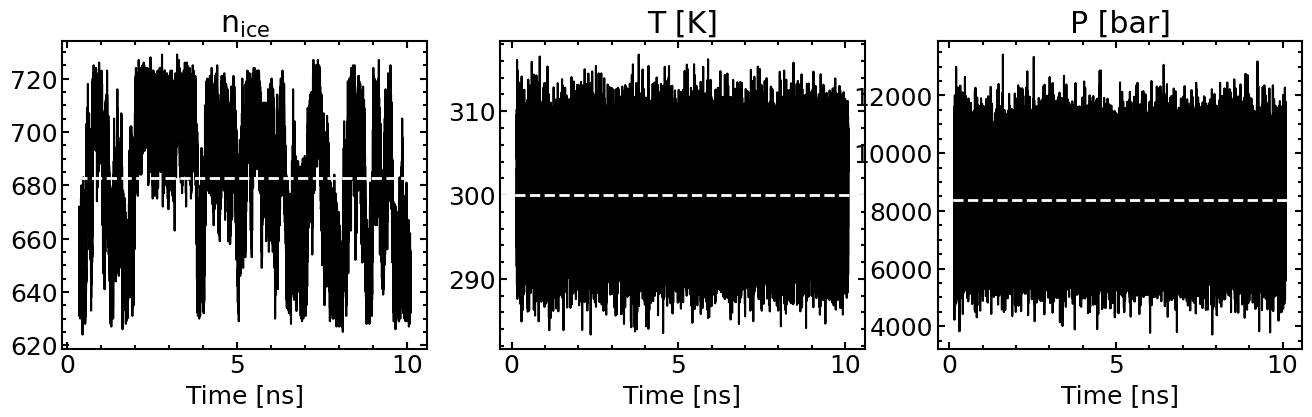

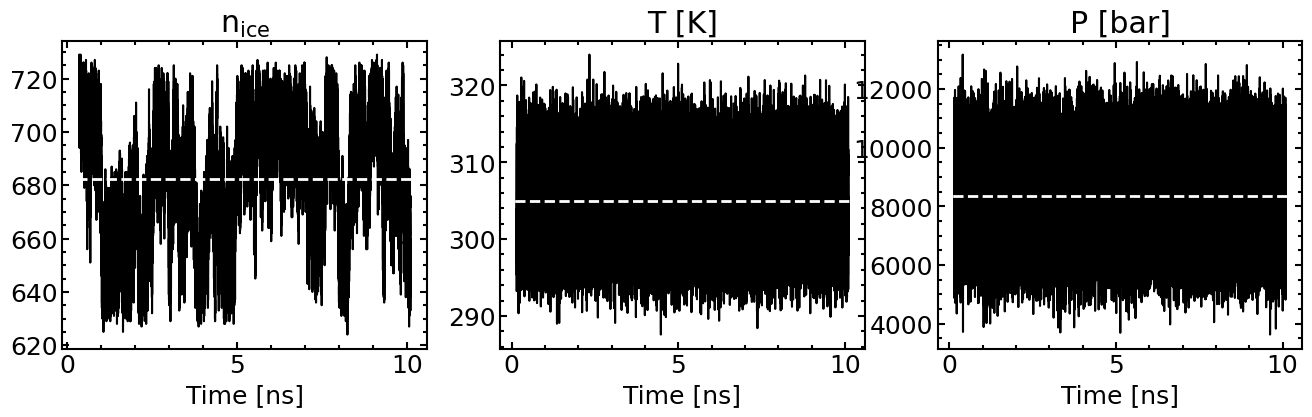

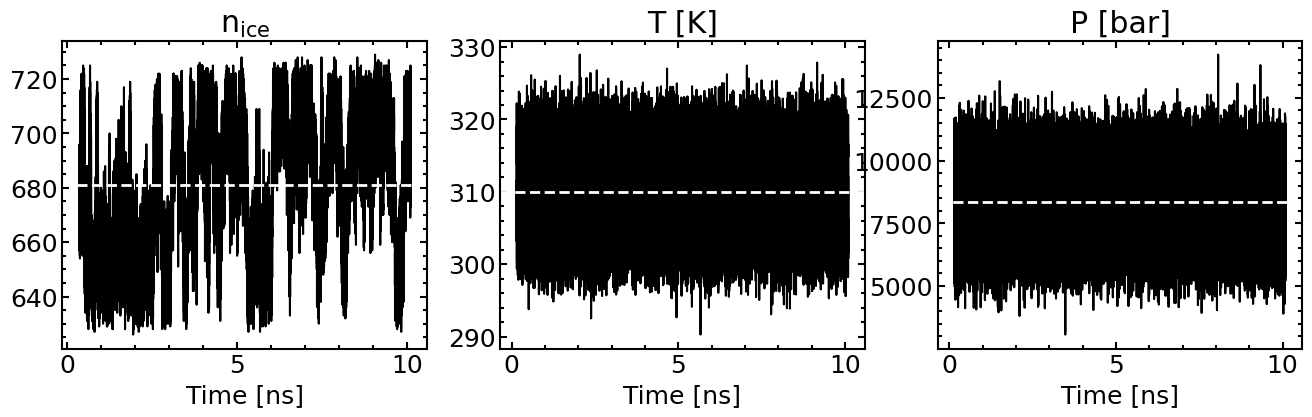

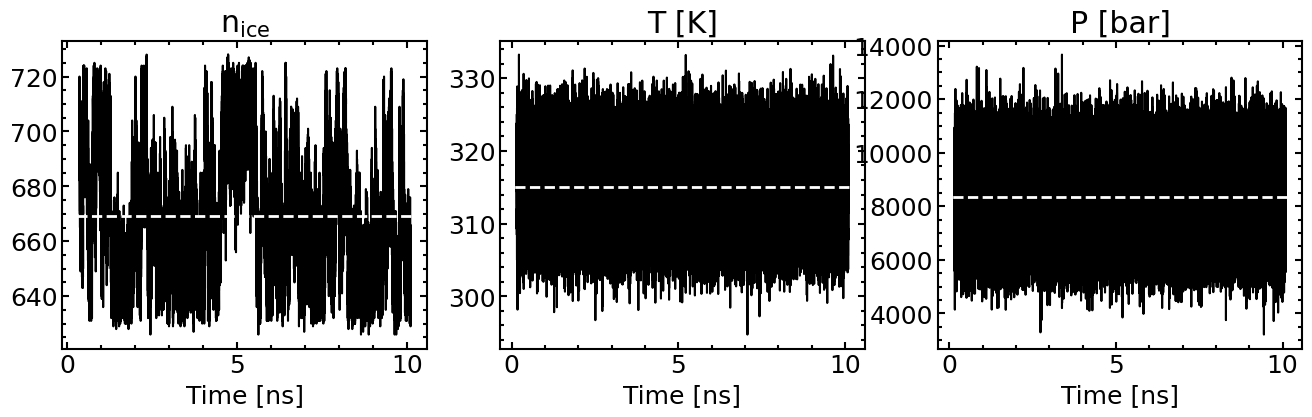

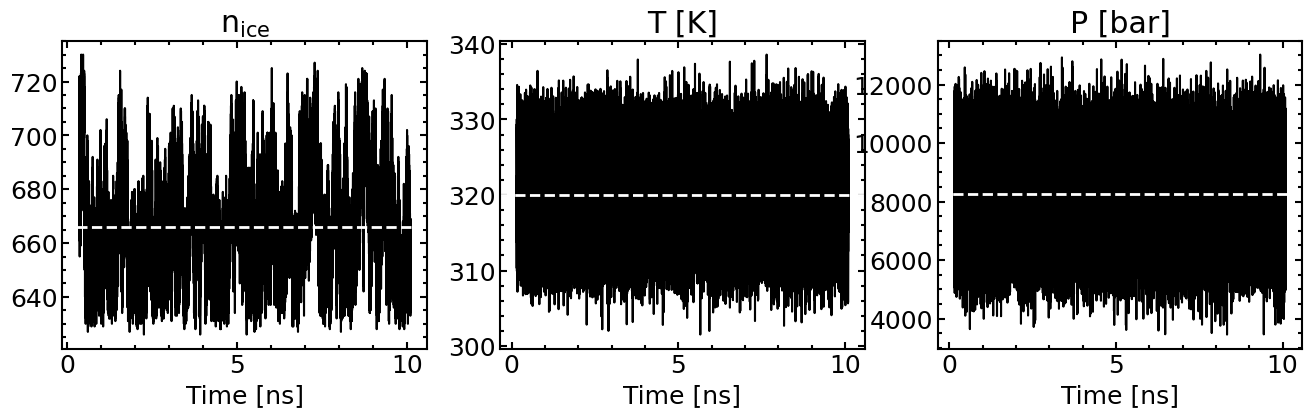

In [159]:
for T in np.linspace(300, 320, 5, dtype=int):
    plot_stats(f'../../full/vi/8000_bar/2-coex/{T}', skip=1000)

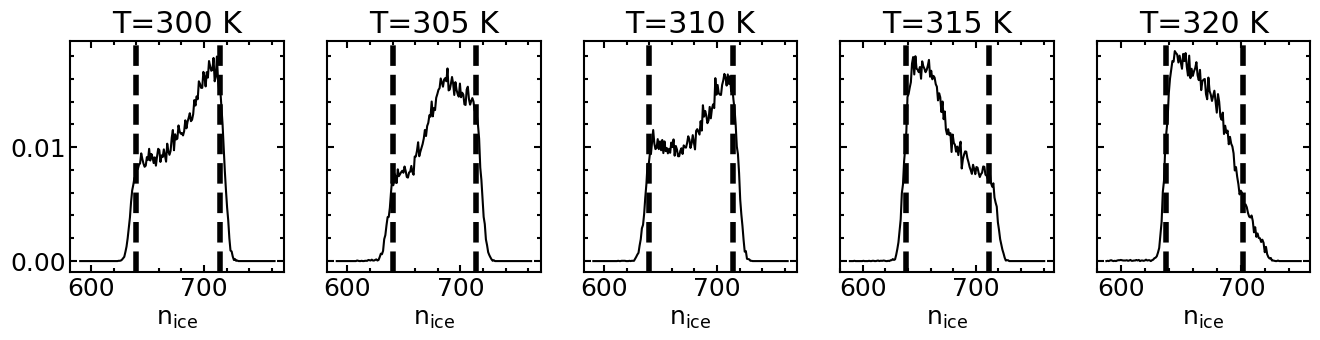

In [97]:
fig, ax = plt.subplots(figsize=(16,3), ncols=5, sharey=True)

for i, T in enumerate(range(300,321,5)):
    path = f'../../full/vi/8000_bar/2-coex/{T}'
    data = np.loadtxt(f'{path}/COLVAR')

    dpl=0.05 # Lower probability range for strict histogram
    dph=0.05 # Upper probability range for strict histogram
    dh=1     # Bin size used for histogram
    NIGNORE_STANDARD=2000 # Ignore the first 1500 frames
    atm_to_gpa=0.000101325

    time_ns = data[:,0]/1E3
    number_of_ice  = data[:,-1]

    histo, bin_edges = np.histogram(number_of_ice,bins=1000)
    n_ice_mid=0.5*(bin_edges[1:]+bin_edges[:-1])

    # Determine outer range of strict collective variable histogram
    cumsum=np.cumsum(histo)
    cumsum=cumsum/cumsum.max()
    difference=np.abs(cumsum-dpl)
    ns=int(n_ice_mid[np.where(difference==difference.min())[0][0]])
    difference=np.abs(cumsum-(1-dph))
    nf=int(n_ice_mid[np.where(difference==difference.min())[0][0]])


    # Plot biased histogram
    num_ice_bins=[i for i in range(ns,nf+1)]
    bins2=[i for i in range(ns-50,nf+50)]
    histo, bin_edges = np.histogram(number_of_ice,bins=bins2[::dh],density=True)
    n_ice_mid=0.5*(bin_edges[1:]+bin_edges[:-1])

    ax[i].plot(n_ice_mid,histo, c='k')
    ax[i].axvline(x=ns,linewidth=4, color='k',ls='--')
    ax[i].axvline(x=nf,linewidth=4, color='k',ls='--')
    ax[i].set_title(f'T={T} K')
    ax[i].set_xlabel('$\mathrm{n_{ice}}$')

Text(0, 0.5, '$\\Delta$G$_{\\mathrm{liq}\\to \\mathrm{ice}}$ (kJ mol$^{-1}$)')

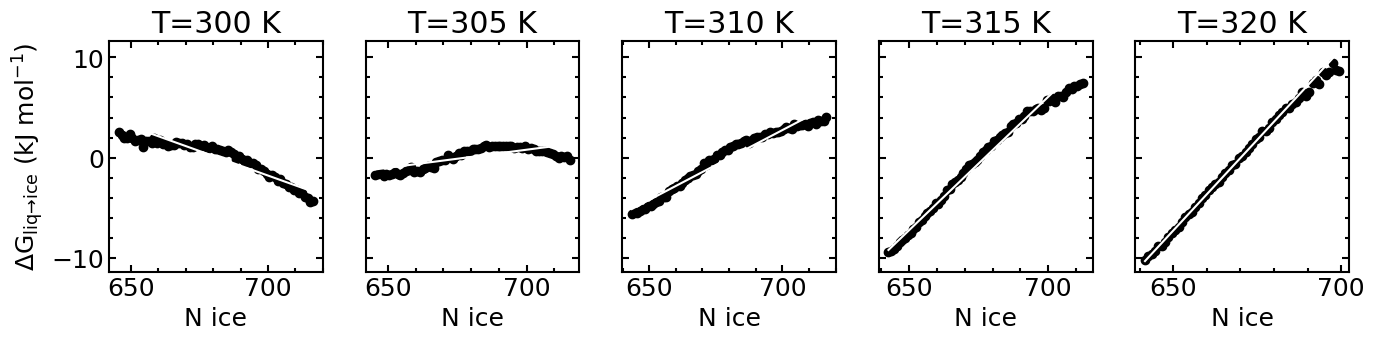

In [151]:
from scipy.optimize import curve_fit

def linear_fn(x, a, b):
    return a*x + b

fig, ax = plt.subplots(figsize=(16,3), ncols=5, sharey=True)

colors = plt.cm.viridis(np.linspace(0,1,5))
colors = ['k']*5
for i, T in enumerate(range(300,321,5)):
    path = f'../../full/vi/8000_bar/2-coex/{T}'
    data = np.loadtxt(f'{path}/COLVAR')
    
    ign = 1500
    number_of_ice  = data[ign:,2]
    bias_potential = data[ign:,-3]

    histo, bin_edges = np.histogram(number_of_ice,bins=1000)
    n_ice_mid=0.5*(bin_edges[1:]+bin_edges[:-1])

    # Determine outer range of strict collective variable histogram
    cumsum=np.cumsum(histo)
    cumsum=cumsum/cumsum.max()
    difference=np.abs(cumsum-dpl)
    ns=int(n_ice_mid[np.where(difference==difference.min())[0][0]])
    difference=np.abs(cumsum-(1-dph))
    nf=int(n_ice_mid[np.where(difference==difference.min())[0][0]])


    # Plot biased histogram
    num_ice_bins=[i for i in range(ns,nf+1)]

    beta = 1./(0.00831441001626*T) # 1/(kJ/mol)

    logweights = beta*bias_potential
    logweights -= np.amax(logweights)

    bins=num_ice_bins[::dh]
    histo, bin_edges = np.histogram(number_of_ice,weights=np.exp(logweights),bins=bins)
    histo_error = np.sqrt(np.histogram(number_of_ice, bins=bins, weights=np.exp(logweights)**2)[0])
    bin_centers = (bin_edges[1:]+bin_edges[:-1])/2

    fes = -(1/beta)*np.log(histo)
    fes -= np.mean(fes)

    fes_error = (1/beta)*histo_error/histo

    popt, pcov = curve_fit(linear_fn, bin_centers, fes, sigma=fes_error)

    n_water = bin_centers
    fes_linear = linear_fn(bin_centers,*popt)
    perr = np.sqrt(np.diag(pcov))[0]
    chem_pot = [popt[0],perr]

    ax[i].scatter(n_water,fes, c=colors[i])
    ax[i].plot(n_water,fes_linear, c='w')
    ax[i].set_title(f'T={T} K')   
    ax[i].set_xlabel('N ice')
ax[0].set_ylabel(r'$\Delta$G$_{\mathrm{liq}\to \mathrm{ice}}$ (kJ mol$^{-1}$)')

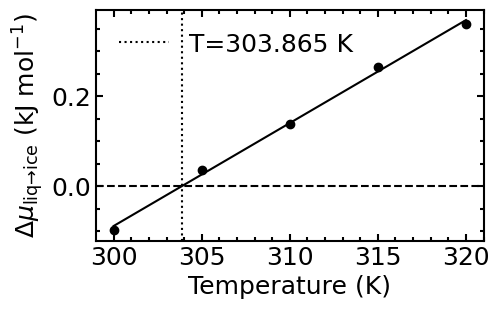

In [178]:
chem_pot_lst = np.zeros((5,3))
for i, T in enumerate(range(300,321,5)):
    path = f'../../full/vi/8000_bar/2-coex/{T}'
    data = np.loadtxt(f'{path}/COLVAR')

    number_of_ice  = data[ign:,2]
    bias_potential = data[ign:,-3]

    histo, bin_edges = np.histogram(number_of_ice,bins=1000)
    n_ice_mid=0.5*(bin_edges[1:]+bin_edges[:-1])

    # Determine outer range of strict collective variable histogram
    cumsum=np.cumsum(histo)
    cumsum=cumsum/cumsum.max()
    difference=np.abs(cumsum-dpl)
    ns=int(n_ice_mid[np.where(difference==difference.min())[0][0]])
    difference=np.abs(cumsum-(1-dph))
    nf=int(n_ice_mid[np.where(difference==difference.min())[0][0]])


    # Plot biased histogram
    num_ice_bins=[i for i in range(ns,nf+1)]

    beta = 1./(0.00831441001626*T) # 1/(kJ/mol)

    logweights = beta*bias_potential
    logweights -= np.amax(logweights)

    bins=num_ice_bins[::dh]
    histo, bin_edges = np.histogram(number_of_ice,weights=np.exp(logweights),bins=bins)
    histo_error = np.sqrt(np.histogram(number_of_ice, bins=bins, weights=np.exp(logweights)**2)[0])
    bin_centers = (bin_edges[1:]+bin_edges[:-1])/2

    fes = -(1/beta)*np.log(histo)
    fes -= np.mean(fes)

    fes_error = (1/beta)*histo_error/histo

    popt, pcov = curve_fit(linear_fn, bin_centers, fes, sigma=fes_error, maxfev=10)

    n_water = bin_centers
    fes_linear = linear_fn(bin_centers,*popt)
    perr = np.sqrt(np.diag(pcov))[0]
    chem_pot = [popt[0],perr]
    chem_pot_lst[i,0] = T
    chem_pot_lst[i,1] = popt[0]
    chem_pot_lst[i,2] = perr
    
    popt, pcov = curve_fit(linear_fn, chem_pot_lst[:,0], chem_pot_lst[:,1], maxfev=1000)


plt.figure(figsize=(5,3))
plt.scatter(chem_pot_lst[:,0],chem_pot_lst[:,1], c='k')
plt.plot(chem_pot_lst[:,0],linear_fn(chem_pot_lst[:,0],*popt), c='k')
plt.axhline(0, ls='--', c='k')
plt.axvline(-popt[1]/popt[0], ls=':', label=f'T={np.round(-popt[1]/popt[0],3)} K', c='k')
plt.ylabel(r'$\Delta\mu_{\mathrm{liq}\to \mathrm{ice}}$ (kJ mol$^{-1}$)')
plt.xlabel('Temperature (K)')    
plt.legend(frameon=False)

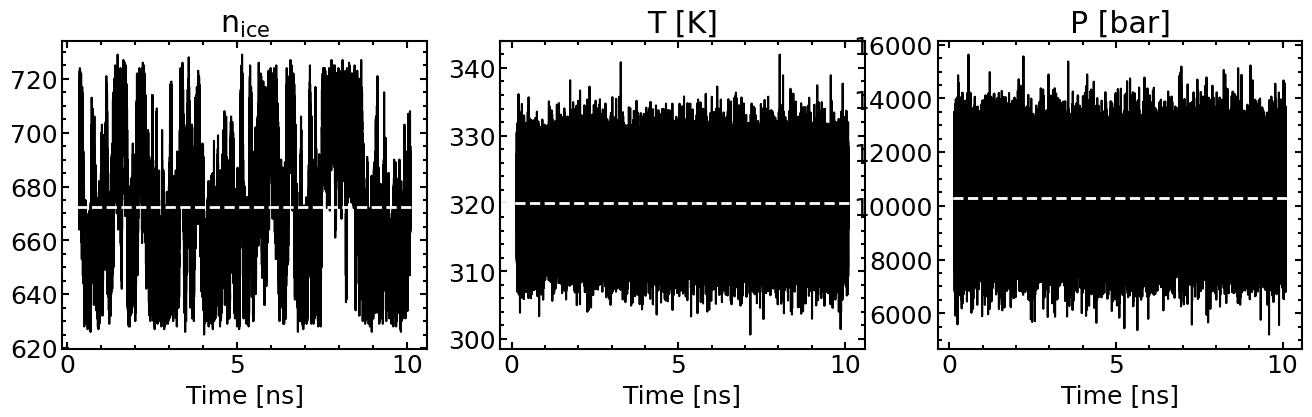

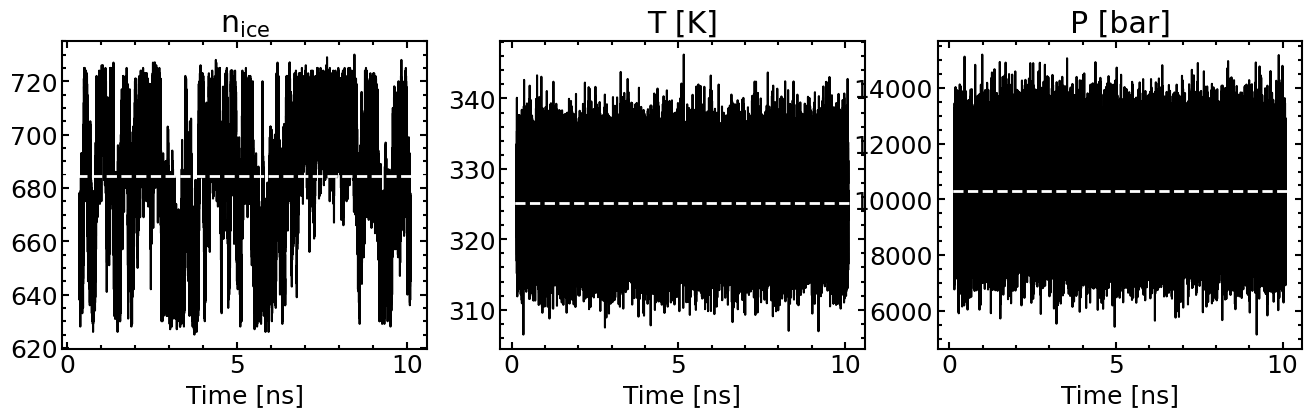

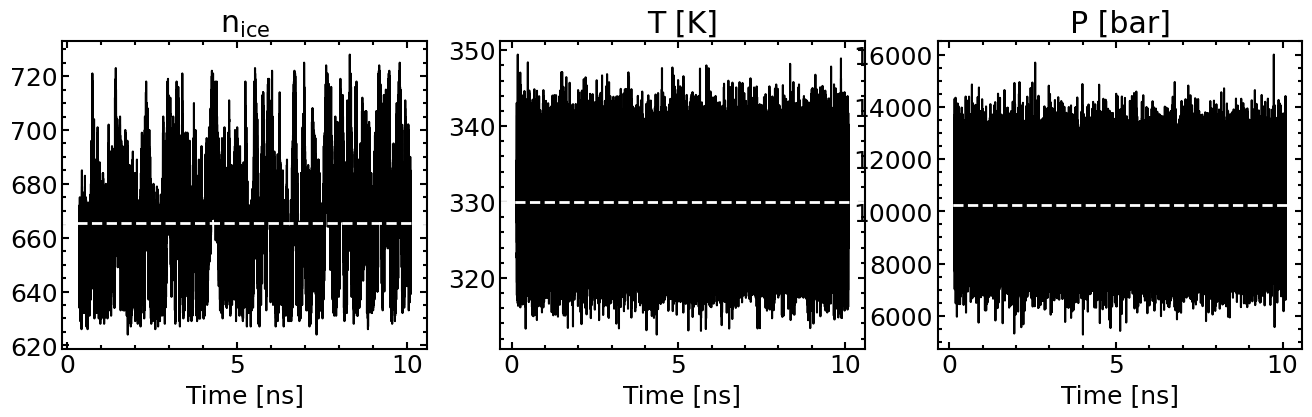

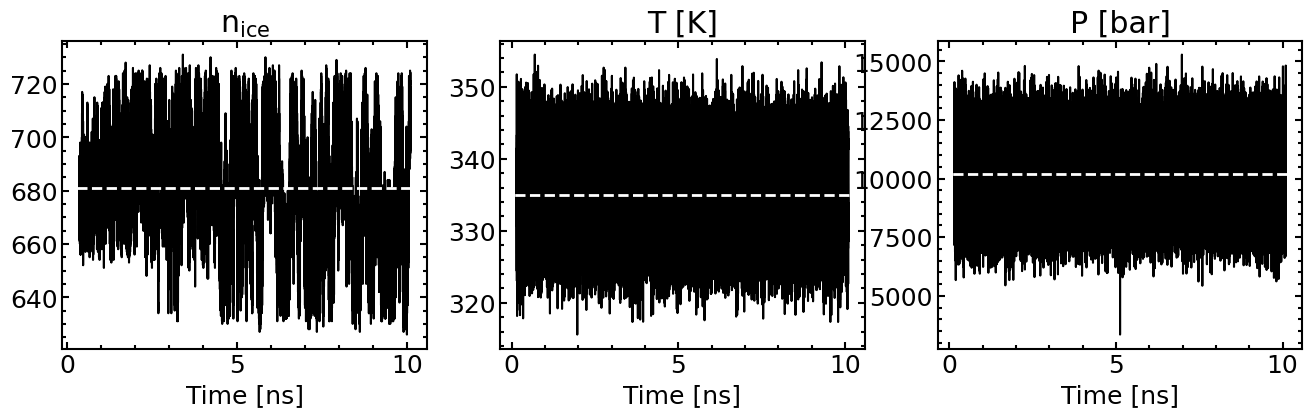

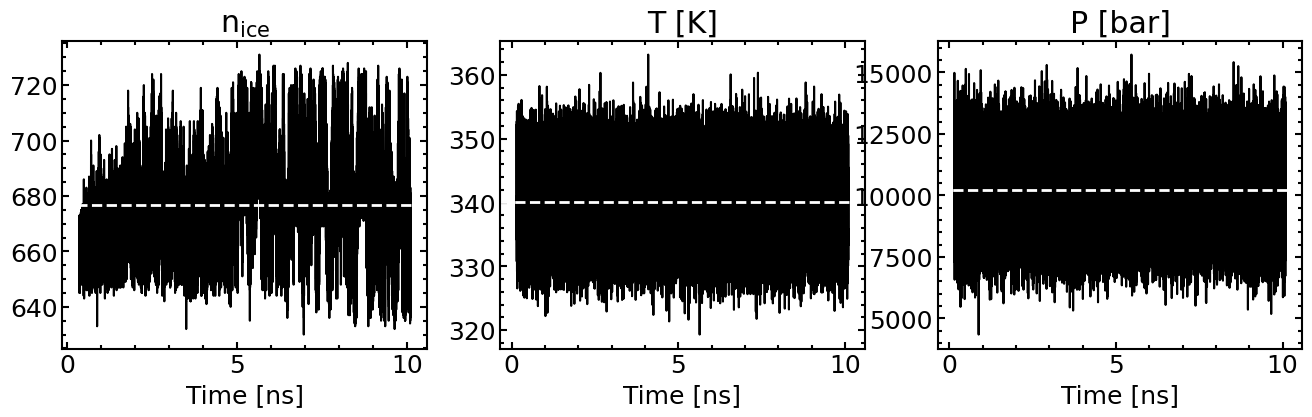

In [160]:
for T in np.linspace(320, 340, 5, dtype=int):
    plot_stats(f'../../full/vi/10000_bar/2-coex/{T}', skip=1000)

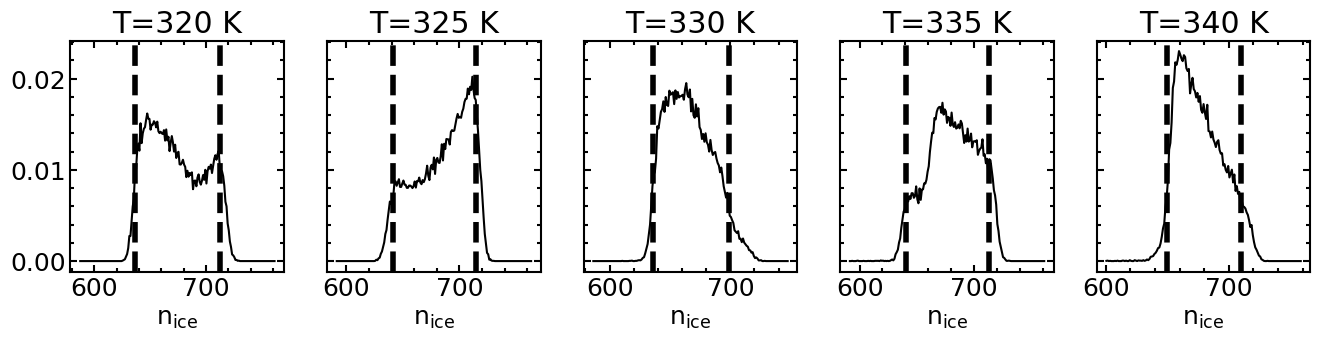

In [103]:
fig, ax = plt.subplots(figsize=(16,3), ncols=5, sharey=True)

for i, T in enumerate(range(320,341,5)):
    path = f'../../full/vi/10000_bar/2-coex/{T}'
    data = np.loadtxt(f'{path}/COLVAR')

    dpl=0.05 # Lower probability range for strict histogram
    dph=0.05 # Upper probability range for strict histogram
    dh=1     # Bin size used for histogram
    NIGNORE_STANDARD=2000 # Ignore the first 1500 frames
    atm_to_gpa=0.000101325

    time_ns = data[:,0]/1E3
    number_of_ice  = data[:,-1]

    histo, bin_edges = np.histogram(number_of_ice,bins=1000)
    n_ice_mid=0.5*(bin_edges[1:]+bin_edges[:-1])

    # Determine outer range of strict collective variable histogram
    cumsum=np.cumsum(histo)
    cumsum=cumsum/cumsum.max()
    difference=np.abs(cumsum-dpl)
    ns=int(n_ice_mid[np.where(difference==difference.min())[0][0]])
    difference=np.abs(cumsum-(1-dph))
    nf=int(n_ice_mid[np.where(difference==difference.min())[0][0]])


    # Plot biased histogram
    num_ice_bins=[i for i in range(ns,nf+1)]
    bins2=[i for i in range(ns-50,nf+50)]
    histo, bin_edges = np.histogram(number_of_ice,bins=bins2[::dh],density=True)
    n_ice_mid=0.5*(bin_edges[1:]+bin_edges[:-1])

    ax[i].plot(n_ice_mid,histo, c='k')
    ax[i].axvline(x=ns,linewidth=4, color='k',ls='--')
    ax[i].axvline(x=nf,linewidth=4, color='k',ls='--')
    ax[i].set_title(f'T={T} K')
    ax[i].set_xlabel('$\mathrm{n_{ice}}$')

/home/users/saadie5f/miniconda3/envs/ace/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:828: RuntimeWarning: divide by zero encountered in divide
  transform = 1.0 / sigma


Text(0, 0.5, '$\\Delta$G$_{\\mathrm{liq}\\to \\mathrm{ice}}$ (kJ mol$^{-1}$)')

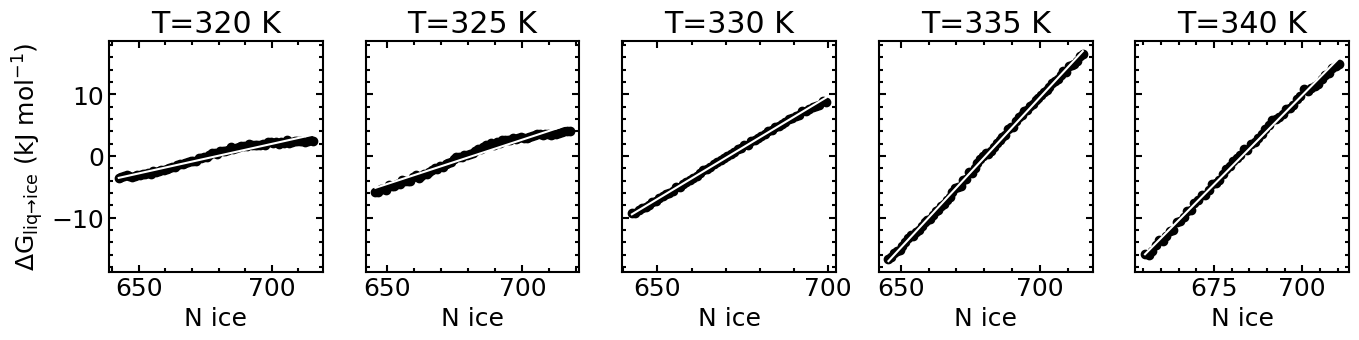

In [146]:
from scipy.optimize import curve_fit

def linear_fn(x, a, b):
    return a*x + b

fig, ax = plt.subplots(figsize=(16,3), ncols=5, sharey=True)

colors = plt.cm.viridis(np.linspace(0,1,5))
colors = ['k']*5
for i, T in enumerate(range(320,341,5)):
    path = f'../../full/vi/10000_bar/2-coex/{T}'
    data = np.loadtxt(f'{path}/COLVAR')
    
    ign = 2000
    number_of_ice  = data[ign:,2]
    bias_potential = data[ign:,-3]

    histo, bin_edges = np.histogram(number_of_ice,bins=1000)
    n_ice_mid=0.5*(bin_edges[1:]+bin_edges[:-1])

    # Determine outer range of strict collective variable histogram
    cumsum=np.cumsum(histo)
    cumsum=cumsum/cumsum.max()
    difference=np.abs(cumsum-dpl)
    ns=int(n_ice_mid[np.where(difference==difference.min())[0][0]])
    difference=np.abs(cumsum-(1-dph))
    nf=int(n_ice_mid[np.where(difference==difference.min())[0][0]])


    # Plot biased histogram
    num_ice_bins=[i for i in range(ns,nf+1)]

    beta = 1./(0.00831441001626*T) # 1/(kJ/mol)

    logweights = beta*bias_potential
    logweights -= np.amax(logweights)
    
    dh = 1
    bins=num_ice_bins[::dh]
    histo, bin_edges = np.histogram(number_of_ice,weights=np.exp(logweights),bins=bins)
    histo_error = np.sqrt(np.histogram(number_of_ice, bins=bins, weights=np.exp(logweights)**2)[0])
    bin_centers = (bin_edges[1:]+bin_edges[:-1])/2

    fes = -(1/beta)*np.log(histo)
    fes -= np.mean(fes)
    

    fes_error = (1/beta)*histo_error/histo

    try:
        popt, pcov = curve_fit(linear_fn, bin_centers, fes, sigma=fes_error, maxfev=1000)
    except:
        popt, pcov = curve_fit(linear_fn, bin_centers, fes, maxfev=1000)

    n_water = bin_centers
    
    fes_linear = linear_fn(bin_centers,*popt)
    
    perr = np.sqrt(np.diag(pcov))[0]
    chem_pot = [popt[0],perr]
    
    ax[i].scatter(n_water,fes, c=colors[i])
    ax[i].plot(n_water,fes_linear, c='w')
    ax[i].set_title(f'T={T} K')   
    ax[i].set_xlabel('N ice')
ax[0].set_ylabel(r'$\Delta$G$_{\mathrm{liq}\to \mathrm{ice}}$ (kJ mol$^{-1}$)')

/home/users/saadie5f/miniconda3/envs/ace/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:828: RuntimeWarning: divide by zero encountered in divide
  transform = 1.0 / sigma


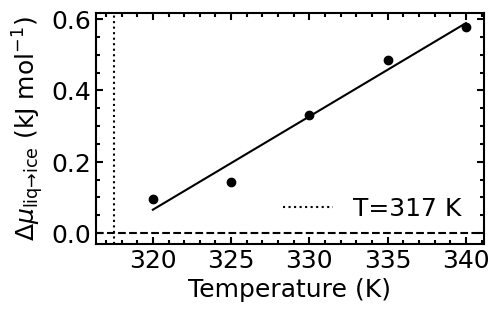

In [148]:
chem_pot_lst = np.zeros((5,3))
for i, T in enumerate(range(320,341,5)):
    path = f'../../full/vi/10000_bar/2-coex/{T}'
    data = np.loadtxt(f'{path}/COLVAR')

    number_of_ice  = data[ign:,2]
    bias_potential = data[ign:,-3]

    histo, bin_edges = np.histogram(number_of_ice,bins=1000)
    n_ice_mid=0.5*(bin_edges[1:]+bin_edges[:-1])

    # Determine outer range of strict collective variable histogram
    cumsum=np.cumsum(histo)
    cumsum=cumsum/cumsum.max()
    difference=np.abs(cumsum-dpl)
    ns=int(n_ice_mid[np.where(difference==difference.min())[0][0]])
    difference=np.abs(cumsum-(1-dph))
    nf=int(n_ice_mid[np.where(difference==difference.min())[0][0]])


    # Plot biased histogram
    num_ice_bins=[i for i in range(ns,nf+1)]

    beta = 1./(0.00831441001626*T) # 1/(kJ/mol)

    logweights = beta*bias_potential
    logweights -= np.amax(logweights)

    bins=num_ice_bins[::dh]
    histo, bin_edges = np.histogram(number_of_ice,weights=np.exp(logweights),bins=bins)
    histo_error = np.sqrt(np.histogram(number_of_ice, bins=bins, weights=np.exp(logweights)**2)[0])
    bin_centers = (bin_edges[1:]+bin_edges[:-1])/2

    fes = -(1/beta)*np.log(histo)
    fes -= np.mean(fes)

    fes_error = (1/beta)*histo_error/histo

    try:
        popt, pcov = curve_fit(linear_fn, bin_centers, fes, sigma=fes_error, maxfev=1000)
    except:
        popt, pcov = curve_fit(linear_fn, bin_centers, fes, maxfev=1000)
        
    n_water = bin_centers
    fes_linear = linear_fn(bin_centers,*popt)
    perr = np.sqrt(np.diag(pcov))[0]
    chem_pot = [popt[0],perr]
    chem_pot_lst[i,0] = T
    chem_pot_lst[i,1] = popt[0]
    chem_pot_lst[i,2] = perr
    
    popt, pcov = curve_fit(linear_fn, chem_pot_lst[:,0], chem_pot_lst[:,1], maxfev=1000)


plt.figure(figsize=(5,3))
plt.scatter(chem_pot_lst[:,0],chem_pot_lst[:,1], c='k')
plt.plot(chem_pot_lst[:,0],linear_fn(chem_pot_lst[:,0],*popt), c='k')
plt.axhline(0, ls='--', c='k')
plt.axvline(-popt[1]/popt[0], ls=':', label=f'T={int(np.round(-popt[1]/popt[0],0))} K', c='k')
plt.ylabel(r'$\Delta\mu_{\mathrm{liq}\to \mathrm{ice}}$ (kJ mol$^{-1}$)')
plt.xlabel('Temperature (K)')    
plt.legend(frameon=False)